# Training a Model

Now that I've got data in Hopsworks and the architecture for updating it, I can go ahead and start the process of constructing training data and then training a model.

In [1]:
import pandas as pd
import numpy as np
import os

zip_code = '60603'  # Chicago
country_code = 'US'
city = 'Chicago'

aqi_table_name = f'aqi_{city}_{zip_code}'.lower()

data_path = os.path.join('data', f'{aqi_table_name}.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path, index_col='datetime', parse_dates=True)
    start_date = df.index.max()
    start_date_id = df['id'].max()

In [2]:
df.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,lat,lon,aqi,id
datetime,,,,,,,,,,,,
2020-11-27 00:00:00,410.56,1.90,41.47,7.78,4.71,9.90,15.92,1.44,41.8798,-87.6285,2,0
2020-11-27 01:00:00,377.18,0.72,35.99,12.52,4.65,8.53,13.40,0.97,41.8798,-87.6285,1,1
2020-11-27 02:00:00,347.14,0.34,31.19,16.81,4.59,7.75,11.57,0.71,41.8798,-87.6285,1,2
2020-11-27 03:00:00,337.12,0.27,29.47,17.88,4.53,7.76,10.98,0.64,41.8798,-87.6285,1,3
2020-11-27 04:00:00,337.12,0.31,29.47,16.63,4.65,8.20,11.27,0.64,41.8798,-87.6285,1,4


In [3]:
df.columns

Index(['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'lat', 'lon',
       'aqi', 'id'],
      dtype='object')

In [4]:
need_cols = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi']
df = df[need_cols].copy()

In [5]:
df.dtypes

co       float64
no       float64
no2      float64
o3       float64
so2      float64
pm2_5    float64
pm10     float64
nh3      float64
aqi        int64
dtype: object

### Feature Engineering

Create the future timestamps, generate features, then separate historical and future.

In [6]:
from my_functions import createFeatures

In [7]:
future_start = df.index.max() + pd.Timedelta('1 hours')
future_end = future_start + pd.Timedelta('3 days') - pd.Timedelta('1 hours')

future = pd.date_range(future_start, future_end, freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

In [8]:
df_and_future.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,isFuture
2020-11-27 00:00:00,410.56,1.90,41.47,7.78,4.71,9.90,15.92,1.44,2.0,False
2020-11-27 01:00:00,377.18,0.72,35.99,12.52,4.65,8.53,13.40,0.97,1.0,False
2020-11-27 02:00:00,347.14,0.34,31.19,16.81,4.59,7.75,11.57,0.71,1.0,False
2020-11-27 03:00:00,337.12,0.27,29.47,17.88,4.53,7.76,10.98,0.64,1.0,False
2020-11-27 04:00:00,337.12,0.31,29.47,16.63,4.65,8.20,11.27,0.64,1.0,False


In [9]:
df_and_future.tail()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,isFuture
2023-01-26 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-26 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-26 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-26 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-01-26 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [10]:
df_and_future = createFeatures(df_and_future)
df_and_future['aqi'] = df_and_future['aqi'] - 1

In [11]:
df = df_and_future.query('isFuture==False').copy()
df = df.drop(columns=['isFuture'])
future_w_features = df_and_future.query('isFuture').copy()
future_w_features = future_w_features.drop(columns=['isFuture'])


In [12]:
df.head()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2020-11-27 00:00:00,1.0,0,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 01:00:00,0.0,1,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 02:00:00,0.0,2,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 03:00:00,0.0,3,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-27 04:00:00,0.0,4,4,4,11,2020,332,27,48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.tail()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2023-01-23 05:00:00,0.0,5,0,1,1,2023,23,23,4,243.66,...,6.60,50.78,2.00,0.80,1.22,0.63,1.0,1.0,1.0,2.251742e-07
2023-01-23 06:00:00,0.0,6,0,1,1,2023,23,23,4,243.66,...,6.60,50.07,1.94,0.72,1.14,0.62,1.0,1.0,1.0,2.251742e-07
2023-01-23 07:00:00,0.0,7,0,1,1,2023,23,23,4,247.00,...,6.94,47.92,1.80,0.68,1.13,0.61,1.0,1.0,1.0,2.251742e-07
2023-01-23 08:00:00,1.0,8,0,1,1,2023,23,23,4,253.68,...,9.08,45.78,1.68,0.91,1.55,0.72,1.0,1.0,1.0,2.251742e-07
2023-01-23 09:00:00,1.0,9,0,1,1,2023,23,23,4,257.02,...,10.88,46.49,1.73,1.09,1.85,0.81,1.0,1.0,1.0,2.251742e-07


In [14]:
future_w_features.head()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2023-01-23 10:00:00,NaN,10,0,1,1,2023,23,23,4,257.02,...,10.37,50.07,1.82,1.04,1.82,0.80,1.0,1.0,1.0,2.251742e-07
2023-01-23 11:00:00,NaN,11,0,1,1,2023,23,23,4,257.02,...,9.17,53.64,1.94,0.99,1.75,0.74,1.0,1.0,1.0,2.251742e-07
2023-01-23 12:00:00,NaN,12,0,1,1,2023,23,23,4,253.68,...,8.48,56.51,2.09,0.94,1.70,0.72,1.0,1.0,1.0,2.251742e-07
2023-01-23 13:00:00,NaN,13,0,1,1,2023,23,23,4,250.34,...,8.14,58.65,2.21,0.90,1.63,0.74,1.0,1.0,1.0,2.251742e-07
2023-01-23 14:00:00,NaN,14,0,1,1,2023,23,23,4,250.34,...,8.05,58.65,2.12,0.87,1.56,0.77,1.0,1.0,1.0,2.251742e-07


In [15]:
future_w_features.tail()

,aqi,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,co_lag3d,...,no2_lag3d,o3_lag3d,so2_lag3d,pm2_5_lag3d,pm10_lag3d,nh3_lag3d,aqi_lag3d,aqi_max_lag_3d,aqi_mean_lag_3d,aqi_std_lag_3d
2023-01-26 05:00:00,NaN,5,3,1,1,2023,26,26,4,283.72,...,11.48,59.37,3.79,5.51,6.88,1.54,1.0,2.0,1.291667,0.464306
2023-01-26 06:00:00,NaN,6,3,1,1,2023,26,26,4,287.06,...,13.20,57.22,4.11,5.56,6.94,1.62,1.0,2.0,1.250000,0.442326
2023-01-26 07:00:00,NaN,7,3,1,1,2023,26,26,4,303.75,...,17.65,50.07,4.83,7.03,8.73,1.95,1.0,2.0,1.208333,0.414851
2023-01-26 08:00:00,NaN,8,3,1,1,2023,26,26,4,360.49,...,31.53,34.33,6.08,11.00,13.84,2.85,2.0,2.0,1.208333,0.414851
2023-01-26 09:00:00,NaN,9,3,1,1,2023,26,26,4,420.57,...,45.93,17.70,8.35,15.28,19.42,3.74,2.0,2.0,1.208333,0.414851


## Modeling with XGBoost

Now that I have data to train a model, I want to spend some time talking about model evaluation before I actually dive into training.

The target variable here is the air quality index (AQI), and in this case it ranges from (0 to 4) and is integral (the actual indices are 1 to 5, but I have to change it to 0 to 4 because XGBoost requires 0-indexed categories). Because of the integer constraint, I'm going to pose this machine learning task as a classification one. This will get rid of the need for rounding predictions to the nearest integer, but it also means I need to think a little bit more carefully about evaluating the model.

In classification tasks, model evaluation is extremely important. A common metric for evaluating classification models is accuracy. However, using that metric can cause modelers to fall into a trap of thinking a model is good, when in fact it's not doing any better than just guessing. For example, if I were to flip a fair coin 100 times, and then guess every time that the coin had landed on heads, I would have an accuracy of around 50%. Even though I just guessed every time, I still got an accuracy around 50%. In that case, a machine learning classifier would need to have an accuracy *greater than* 50% to be considered useful. That 50% accuracy is known as a baseline metric. This scenario gets more complicated when there are multiple classes and the classes are not balanced. 

The dataset at hand has a class imbalance, as shown below:

In [16]:
df['aqi'].value_counts()/len(df['aqi'])

0.0    0.477224
1.0    0.378101
2.0    0.073193
3.0    0.058169
4.0    0.013313
Name: aqi, dtype: float64

Say I just guess 0 (remember that's actually an AQI of 1) every time. Then I'll be correct 47.6% of the time. So I need to have a model that is correct more than that. What if I guess randomly, weighted by the share of the distribution each class has? That'll be:

In [17]:
((df['aqi'].value_counts()/len(df['aqi']))**2).sum()

0.37962128908808324

So basically, if I'm using accuracy as a metric to evaluate the model, I need to do better than 37.9% to be confident that the model is better than randomly guessing, and better than 47.6% to be better than just guessing the most common value. This is why accuracy is a misleading metric. A better metric to use would be the log-loss function. 

Recall that predictions with classifiers are made using probabilities, that is, the probability that a given record belongs to a particular class. For example in a binary classification problem, we predict the probablility that a record belongs to the positive class. The log-loss function measures how close a prediction probability is to the corresponding true value. The more a predicted probability diverges from the actual value, the higher the log-loss value is. In other words, a poorer prediction gets a higher log-loss score than a better one. 

The log-loss function $L\big(\hat{p}^{(i)}\big)$ is as follows for a two-class classification, where $\hat{p}^{(i)}$ is the probability that a given record belongs to the positive class and $y^{(i)}$ is the class (0 or 1):
$$L\big(\hat{p}^{(i)}\big)=-\Big(y^{(i)}\log\big(\hat{p}^{(i)}\big)+\big(1-y^{(i)}\big)\log\big(1-\hat{p}^{(i)}\big)\Big)$$

If I plot this for the positive class, $y^{(i)}=1$, we can see that poorer predictions are heavily penalized:

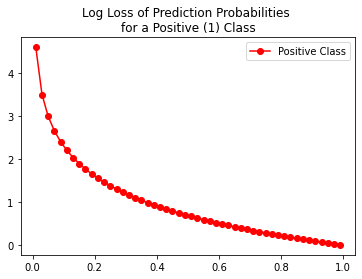

In [18]:
import numpy as np
import matplotlib.pyplot as plt

n = 50
probs = np.linspace(0.01, 0.99, num=n)
y = np.full(n, 1, dtype=int)

def logloss(p, y):
    one = y * np.log(probs)
    two = (1-y)*np.log(1-probs)
    
    return -1*(one+two)

plt.plot(probs, logloss(probs, y), marker='o', color='r', label='Positive Class')
plt.legend()
plt.title('Log Loss of Prediction Probabilities \nfor a Positive (1) Class')
plt.show()

The log-loss metric is provided as a function in Scikit-Learn, which averages the log-loss for every record in the dataset.

Now the question is, what's the baseline log-loss for our dataset? Also, what is the log-loss when I just randomly predict the class, weighted by the share of each class in the distribution?

The baseline log-loss will be the log-loss when I predict a probability of a record belonging to the positive class 48% of the time, since the most prevalent class has a 48% share of the dataset:

In [19]:
n = 100
probs = np.full(n, 0.48, dtype=float)
y = np.concatenate((np.full(48, 1, dtype=float), np.full(52, 0, dtype=float)))

logloss(probs, y).mean()

0.6923469670899614

So I need a log-loss less than 0.69 for the model to be considered better than guessing 0 every time. Now what is the log loss when we just randomly predict the class, weighted by the share of each class in the distribution? That would just be the average of the log-losses for each class:

In [20]:
from sklearn.metrics import log_loss

def calculate_log_loss(class_ratio, multi=10000):
    
    if sum(class_ratio)!=1.0:
        print("warning: Sum of ratios should be 1 for best results")
        class_ratio[-1]+=1-sum(class_ratio)  # add the residual to last class's ratio
    
    actuals=[]
    for i,val in enumerate(class_ratio):
        actuals=actuals+[i for x in range(int(val*multi))]
        

    preds=[]
    for i in range(multi):
        preds+=[class_ratio]

    return (log_loss(actuals, preds))



In [21]:
calculate_log_loss([0.48, 0.38, 0.07, 0.06, 0.01])

1.1209916814687222

So now I have an upper bound on the log-loss to determine if my model is worth it: 0.69. Now I can go ahead and start training the model.

## Training

Alright, so I need to do a little bit of preprocessing. I need to make some cross validation folds so that I can find the best model. After training, I'll write a function to compute some lag features so that I can make predictions into the future.

In [22]:
from sklearn.model_selection import TimeSeriesSplit

In [23]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*90*1, gap=24)

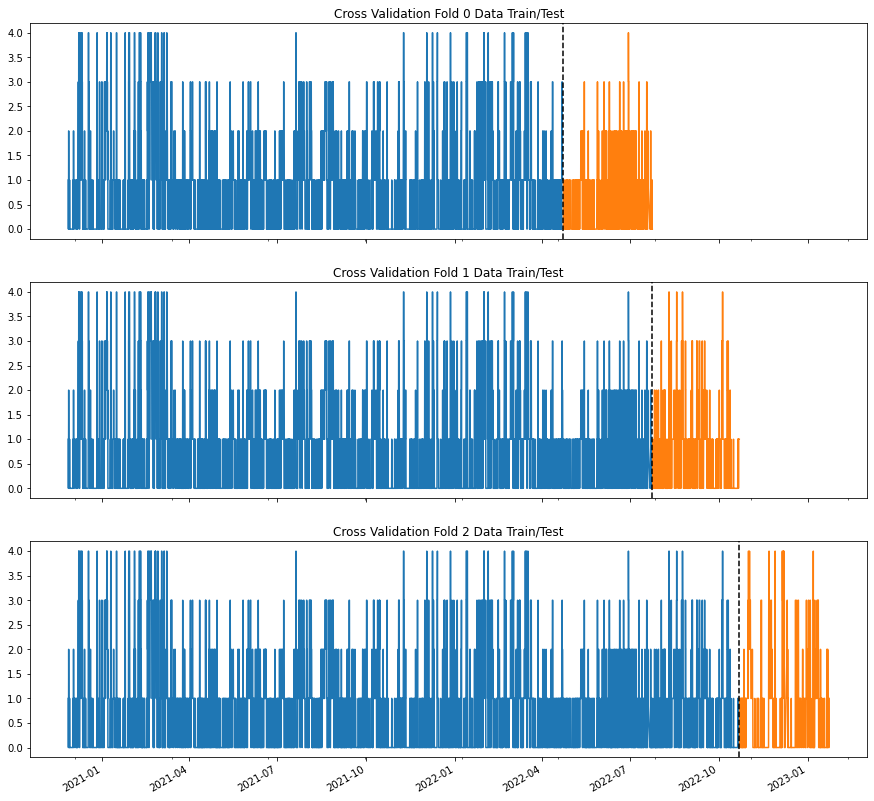

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train_val = df.iloc[train_idx]
    test_val = df.iloc[val_idx]
    train_val['aqi'].plot(ax=axs[fold], 
                          label='Training Set', 
                          title=f'Cross Validation Fold {fold} Data Train/Test')
    test_val['aqi'].plot(ax=axs[fold], 
                          label='Test Set')
    axs[fold].axvline(test_val.index.min(), color='black', ls='--')
    fold += 1    

### Train with Cross Validation

Use cross validation to find some good parameters for the model without overfitting.

In [25]:
df.columns

Index(['aqi', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'co_lag3d', 'no_lag3d', 'no2_lag3d',
       'o3_lag3d', 'so2_lag3d', 'pm2_5_lag3d', 'pm10_lag3d', 'nh3_lag3d',
       'aqi_lag3d', 'aqi_max_lag_3d', 'aqi_mean_lag_3d', 'aqi_std_lag_3d'],
      dtype='object')

In [26]:
import xgboost as xgb

In [27]:
from sklearn.utils.class_weight import compute_sample_weight

In [28]:
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
               'dayofmonth', 'weekofyear', 'co_lag3d', 'no_lag3d', 'no2_lag3d',
               'o3_lag3d', 'so2_lag3d', 'pm2_5_lag3d', 'pm10_lag3d', 'nh3_lag3d',
               'aqi_lag3d', 'aqi_max_lag_3d', 'aqi_mean_lag_3d', 'aqi_std_lag_3d']
    target = 'aqi'
    
    x_train = train[features]
    y_train = train[target]
    
    x_test = test[features]
    y_test = test[target]
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=train[target])

    clf = xgb.XGBClassifier(n_estimators=1000, 
                            booster='gbtree',
                            early_stopping_rounds=50,
                            max_depth=4,
                            learning_rate=0.01
                           )
    
    clf.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100,
#             sample_weight=sample_weights  # surprisingly get a little better performance without
           )
    
    y_pred = clf.predict_proba(x_test)
    preds.append(y_pred)
    score = log_loss(y_test, y_pred)
    scores.append(score)

[0]	validation_0-mlogloss:1.60220	validation_1-mlogloss:1.60178
[100]	validation_0-mlogloss:1.20215	validation_1-mlogloss:1.19069
[200]	validation_0-mlogloss:1.05309	validation_1-mlogloss:1.05155
[300]	validation_0-mlogloss:0.97601	validation_1-mlogloss:0.99831
[400]	validation_0-mlogloss:0.92858	validation_1-mlogloss:0.97140
[500]	validation_0-mlogloss:0.89376	validation_1-mlogloss:0.96013
[600]	validation_0-mlogloss:0.86679	validation_1-mlogloss:0.95694
[700]	validation_0-mlogloss:0.84356	validation_1-mlogloss:0.95464
[776]	validation_0-mlogloss:0.82711	validation_1-mlogloss:0.95474
[0]	validation_0-mlogloss:1.60206	validation_1-mlogloss:1.60315
[100]	validation_0-mlogloss:1.19537	validation_1-mlogloss:1.25777
[200]	validation_0-mlogloss:1.04572	validation_1-mlogloss:1.14891
[300]	validation_0-mlogloss:0.97042	validation_1-mlogloss:1.10827
[400]	validation_0-mlogloss:0.92457	validation_1-mlogloss:1.09352
[500]	validation_0-mlogloss:0.89167	validation_1-mlogloss:1.08838
[600]	validati

In [29]:
importances = pd.DataFrame({'feature_importance': clf.feature_importances_}, 
                           index=features).sort_values(by='feature_importance', ascending=False)
print(importances)
print('CV Fold Scores: ', scores)
print(f'Average Score: {np.mean(scores):0.4f}')

                 feature_importance
o3_lag3d                   0.085438
quarter                    0.074647
dayofyear                  0.072681
hour                       0.071950
weekofyear                 0.067669
dayofmonth                 0.054643
month                      0.050545
no_lag3d                   0.049547
aqi_std_lag_3d             0.048017
year                       0.045794
aqi_max_lag_3d             0.045628
dayofweek                  0.044576
no2_lag3d                  0.042863
aqi_mean_lag_3d            0.040703
aqi_lag3d                  0.036568
pm10_lag3d                 0.036192
pm2_5_lag3d                0.035014
nh3_lag3d                  0.033742
co_lag3d                   0.032086
so2_lag3d                  0.031697
CV Fold Scores:  [0.9545429169441815, 1.0866760332413294, 1.1741835890820733]
Average Score: 1.0718


It's kinda of clear from extensive testing that I'm not able to get below that 0.69 threshold. I spent a while learning about feature engineering for time series forecasting and then implemented that knowledge into the data at hand. Not really getting anywhere below 1.0 unfortunately. It's okay though, this is a learning project and I'll do better on future projects!

### Retraining with Full Dataset

In [30]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
           'dayofmonth', 'weekofyear', 'co_lag3d', 'no_lag3d', 'no2_lag3d',
           'o3_lag3d', 'so2_lag3d', 'pm2_5_lag3d', 'pm10_lag3d', 'nh3_lag3d',
           'aqi_lag3d', 'aqi_max_lag_3d', 'aqi_mean_lag_3d', 'aqi_std_lag_3d']
target = 'aqi'

x_all = df[features]
y_all = df[target]

sample_weights = compute_sample_weight(class_weight='balanced', 
                                       y=df[target])

clf = xgb.XGBClassifier(n_estimators=1000, 
                        booster='gbtree',
                        early_stopping_rounds=50,
                        max_depth=4,
                        learning_rate=0.01
                       )

clf.fit(x_all, y_all, eval_set=[(x_all, y_all)], 
        verbose=100, sample_weight=sample_weights)

[0]	validation_0-mlogloss:1.60668
[100]	validation_0-mlogloss:1.43372
[200]	validation_0-mlogloss:1.34181
[300]	validation_0-mlogloss:1.28336
[400]	validation_0-mlogloss:1.24139
[500]	validation_0-mlogloss:1.20475
[600]	validation_0-mlogloss:1.17433
[700]	validation_0-mlogloss:1.14963
[800]	validation_0-mlogloss:1.12640
[900]	validation_0-mlogloss:1.10481
[999]	validation_0-mlogloss:1.08457


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Predict Future

In [31]:
preds = clf.predict(future_w_features[features])

In [32]:
preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

### Dump Model

In [33]:
import joblib
import os

# The 'aqi_model' directory will be saved to the model registry
model_dir = 'aqi_model'
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
    
joblib.dump(clf, model_dir + '/xgboost_aqi_model.pkl')

['aqi_model/xgboost_aqi_model.pkl']